In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Homework 4: Let's simulate a microscope

Due Date: Friday, April 5th at midnight

The goal of this homework assignment is to create a physically accurate simulation of an optical microscope. This should give you an idea of how to treat an imaging system as a black box linear system, by performing filtering in the Fourier domain. This type of model is also applicable to imaging with other EM radiation, ultrasound, MRI, CT etc. Before I forget, I'd like to thank Eric Thompson for helping me translate a simple model that I originally wrote in Matlab into Python.

This simulation will: 

1. Illuminate a thin sample (with finite thickness variations) with light from a particular angle
2. The emerging light will then propagate from the sample to the microscope lens,
3. The light will be filtered by the microscope lens, 
4. And then will continue to the image sensor and will be detected by the image sensor.

Because things are small within a microscope, you have to treat light as a wave. So, we'll be defining the sample, illumination and lens effects as complex-valued vectors.

As a first step, you should define all of the variables of interest and an (x,y) coordinate system for the sample. The variables will include the size of the sample, which we can make 0.25 mm (this is a normal size for a microscope sample), the number of discrete elements we'll split the sample up into (1000), the wavelength of light ($\lambda$=0.5 $\mu$m) and the size of the smallest feature that we'll be able to see within the simulated sample, $\Delta x$, which we'll set at half the wavelength of light. You can use the np.linspace function to create x and y axes, and the np.meshgrid function to generate a 2D array of x and y values that will be useful later.

In [2]:
wavelength = .5e-3          # units are mm
delta_x = wavelength/2
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

#make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = x
[xx, yy] = np.meshgrid(x,x)

Next, read in an image to use as the test sample. I have included a test target image that is useful to check the resolution of the microscope with. In addition to simulating a sample with this image, please feel free to also use another image of your choice to create a simulated sample. 

For the assignment, please use the test target image to simulate two different types of sample: one that has both absorption and phase delay (as in the code below), and then later for question (c), one that is only absorptive.

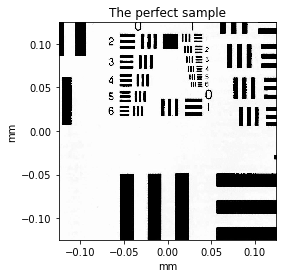

In [3]:
#Define sample absorption
sample = plt.imread('resolution_target.png')
sample = sample/sample.max()
#Add in sample phase delay 
sample_phase = sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay
sample_abs = np.abs(sample)

#show absolute value of sample = its absorption
plt.figure()
plt.imshow(sample_abs, extent=(x[0], x[-1], y[0], y[-1]))
plt.title('The perfect sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Next, let's model a plane wave hitting this thin sample. I've written down the general form of a plane wave for you guys below. Note that you can simulate the plane wave such that it hits the sample at any desired angle ($\theta_x$,$\theta_y$).

In [4]:
#Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

#Define field emerging from sample
emerging_field = illumination_plane_wave*sample

Now, let's propagate this field to the lens aperture plane via a Fourier transform, to create the sample spectrum. It is also helpful to define a set of coordinates $(f_x,f_y)$ at this Fourier transform plane. You can use the $(x,y)$ coordinates that you formed above, as well as the relationship $2f_x^{max}=1/\Delta x$, to define the $(f_x,f_y)$ coordinates. That is,  the full range of the spatial frequency axis is inversely proportional to the smallest step size in the spatial axis. Please go ahead and plot the magnitude of the sample spectrum with a set of marked and labeled axes (like for the sample in space). It is helpful to plot it on a log scale for visualization.

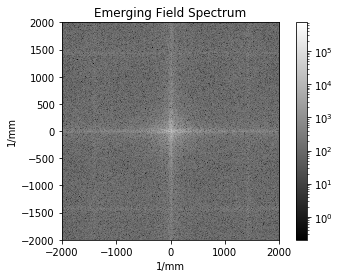

In [5]:
#define total range of spatial frequency axis, 1/mm
fx_max = 1/(2*delta_x)

#make linspace, meshgrid as needed
fx = np.linspace(-fx_max, fx_max, num=num_samples)

# Take 2D fourier transform of sample
ef_fft = np.fft.fft2(emerging_field)
ef_fft = np.fft.fftshift(ef_fft)

# plot the Fourier transform of the sample in inverse mm coordinates
plt.imshow(np.abs(ef_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.colorbar()
plt.xlabel('1/mm')
plt.ylabel('1/mm')
plt.title('Emerging Field Spectrum')
plt.show()

# plt.imshow(abs(np.fft.ifft(np.fft.ifftshift(ef_fft))))
# plt.show()

Next, define the lens transfer function as a circle with a finite radius in the spatial frequency domain. Inside the circle the value of the transfer function is 1, and outside it is 0. Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates. The diameter is set by a parameter called the lens numerical aperture. 

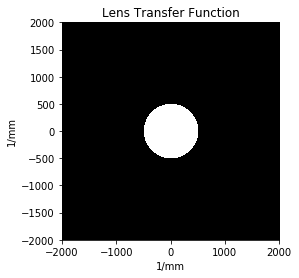

In [6]:
#Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
lens_apert = 1/4

#Define lens transfer function as matrix with 1's within desired radius, 0's outside
def make_lens(lens_apert, size):
    lens = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            dist = np.sqrt((i-size/2)**2+(j-size/2)**2)
            if dist < lens_apert/2*size:
                lens[i,j] = 1
    return lens

# Plot what the transfer function looks like
lens = make_lens(lens_apert, len(fx))
plt.imshow(lens, extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
plt.ylabel('1/mm')
plt.title('Lens Transfer Function')
plt.show()

You can now filter the sample spectrum with the lens transfer function, propagate this filtered spectrum to the image plane, and sample it on a detector that only detects the intensity of light, as we've shown in class. Let's assume the magnification of the lens is 5X (meaning the image of the sample at the detector plane is 5X larger than it is at the lens plane). Please display the resulting image on a new coordinate system, $(x',y')$ which represent the coordinates at the detector plane.

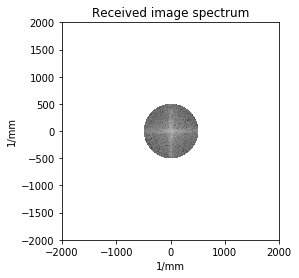

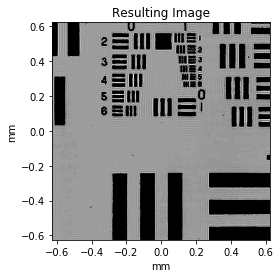

In [7]:
#Create filtered sample spectrum
filtered_sample_fft = lens*ef_fft
plt.imshow(np.abs(filtered_sample_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
plt.ylabel('1/mm')
plt.title('Received image spectrum')
plt.show()

#Define spatial coordinates at image plane, using magnification
x_dash = x*5

#Propagate filtered sample spectrum to image plane
detected_img = np.fft.ifft2(filtered_sample_fft)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img = abs(detected_img)**2

#Plot resulting image
plt.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]), cmap='gray')
plt.xlabel('mm')
plt.ylabel('mm')
plt.title('Resulting Image')
plt.show()

Ok, you've simulated a microscope image! Great! Now let's try to change a few parameters to see what happens. Please try out the following tests and briefly answer the following questions:

(a) Let's try changing the illumination angle by 5 degrees. What happens to sample spectrum at the aperture plane? Why does that change the appearance of the image? Try again with a larger angle of illumination that changes the appearance of the image dramatically, such that the background of the image becomes black. This is called a dark field image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur?

(b) Let's also change the lens numerical aperture. Instead of a circle having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with 10%. How does the appearance of the image change? And why? Next, let's try a wider lens with 50%. Describe how the appearance of the image changes and why. 

(c) In the code that we provided, the sample both absorbed light and phase-delayed it at different locations across its surface. Now try to repeat the above exercise with a perfectly flat sample, that only absorbs light, and provides a constant phase delay across its surface. How does the sample spectrum change when you remove the phase delay term? How does this alter the appearence of the image, if at all, at different illumination angles?

(d) (bonus problem for extra credit) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why?



# (a)

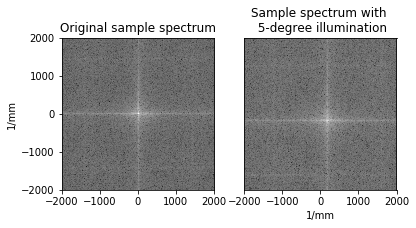

In [8]:
# Redefine plane wave with 5-angle illumination
plane_wave_angle_x5 = 5 * np.pi/180
plane_wave_angle_y5 = 5 * np.pi/180
illumination_plane_wave5 = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x5) * xx + np.sin(plane_wave_angle_y5) * yy))

emerging_field5 = illumination_plane_wave5*sample

# Take 2D fourier transform of emerging field with 5-degree illu
ef_fft5 = np.fft.fft2(emerging_field5)
ef_fft5 = np.fft.fftshift(ef_fft5)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Original sample spectrum')

ax1.imshow(np.abs(ef_fft5), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Sample spectrum with \n 5-degree illumination')
plt.show()

#### With 5-degree illumination angle, the sample spectrum is shifted to the lower right corner because the Fourier plane of the emerging field reflects the ray angle at the sample plane

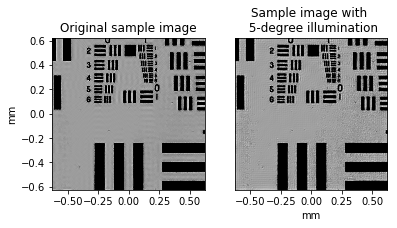

In [9]:
#Create filtered sample spectrum
detected_fft5 = lens*ef_fft5

#Propagate filtered sample spectrum to image plane
detected_img5 = np.fft.ifft2(detected_fft5)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img5 = abs(detected_img5)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img5, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with \n 5-degree illumination')
plt.show()

#### Due to a larger angle of illumination (5 degree from the upper left), the lower right part of the sample will have longer propagation length, leading to more photon absorption. Thus, the signals at this part are lower and more distorted than the upper left part

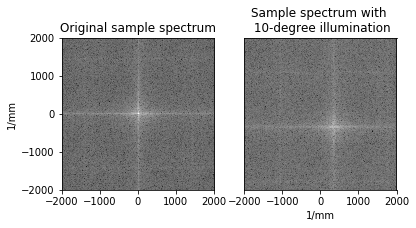

In [10]:
# Redefine plane wave with 10-angle illumination
plane_wave_angle_x10 = 10 * np.pi/180
plane_wave_angle_y10 = 10 * np.pi/180
illumination_plane_wave10 = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x10) * xx + np.sin(plane_wave_angle_y10) * yy))

emerging_field10 = illumination_plane_wave10*sample

# Take 2D fourier transform of emerging field with 5-degree illu
ef_fft10 = np.fft.fft2(emerging_field10)
ef_fft10 = np.fft.fftshift(ef_fft10)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Original sample spectrum')

ax1.imshow(np.abs(ef_fft10), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Sample spectrum with \n 10-degree illumination')
plt.show()

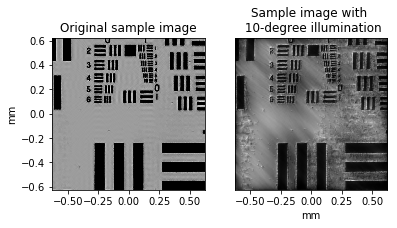

In [11]:
#Create filtered sample spectrum
detected_fft10 = lens*ef_fft10

#Propagate filtered sample spectrum to image plane
detected_img10 = np.fft.ifft2(detected_fft10)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img10 = abs(detected_img10)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img10, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with \n 10-degree illumination')
plt.show()

#### With 10-degree illumination, we can clearly see a lot of effects induced by the sample thickness. The lower left of the image has a lot of distortion caused by the scattered photons. These photons are once scattered by the part of the sample closer to the source, and then illuminated on to the lower right of the sample, leading to the distorted detected image at the lower right part. The "shadow" is obviously caused by the shift of the ray angle.

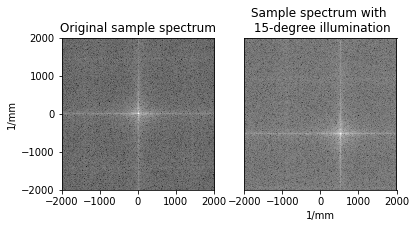

In [12]:
# Redefine plane wave with 15-angle illumination
plane_wave_angle_x15 = 15 * np.pi/180
plane_wave_angle_y15 = 15 * np.pi/180
illumination_plane_wave15 = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x15) * xx + np.sin(plane_wave_angle_y15) * yy))

emerging_field15 = illumination_plane_wave15*sample

# Take 2D fourier transform of emerging field with 5-degree illu
ef_fft15 = np.fft.fft2(emerging_field15)
ef_fft15 = np.fft.fftshift(ef_fft15)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Original sample spectrum')

ax1.imshow(np.abs(ef_fft15), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Sample spectrum with \n 15-degree illumination')
plt.show()

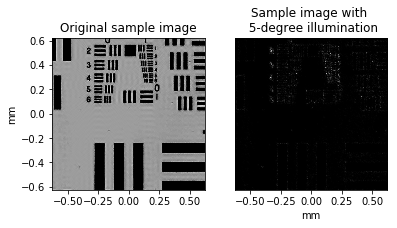

In [13]:
#Create filtered sample spectrum
detected_fft15 = lens*ef_fft15

#Propagate filtered sample spectrum to image plane
detected_img15 = np.fft.ifft2(detected_fft15)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img15 = abs(detected_img15)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img15, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with \n 5-degree illumination')
plt.show()

#### At 15 degree, the background becomes totally dark because this is the critical angle leading to total reflection of photons, preventing them from propagating through the sample.

# (b)

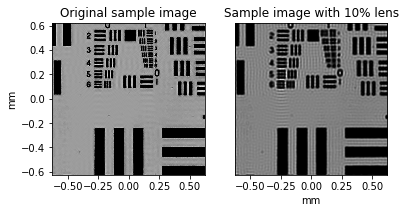

In [14]:
# make smaller lens
lens10 = make_lens(1/10, len(fx))

#Create filtered sample spectrum
filtered_sample_fft10 = lens10*ef_fft

#Propagate filtered sample spectrum to image plane
detected_img10 = np.fft.ifft2(filtered_sample_fft10)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img10 = abs(detected_img10)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img10, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with 10% lens')
plt.show()

#### With smaller lens, a lot of high frequency signals will be filtered out, leading to lower resolution of the detected image (at 5 and 6 regions, we can barely differentiate the details)

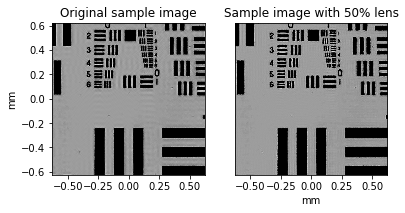

In [15]:
# make larger lens
lens50 = make_lens(1/2, len(fx))

#Create filtered sample spectrum
filtered_sample_fft50 = lens50*ef_fft

#Propagate filtered sample spectrum to image plane
detected_img50 = np.fft.ifft2(filtered_sample_fft50)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img50 = abs(detected_img50)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img50, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with 50% lens')
plt.show()

#### With bigger lens, there is only a small change to the appearance of the image. Since the sample image does not have many very high frequency signals, not many edge details are filtered out.

# (c)

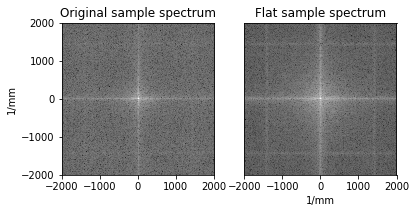

In [16]:
# Make flat sample
sample_flat = plt.imread('resolution_target.png')
sample_flat = sample_flat/sample_flat.max()

# Re-illuminate the sample
emerging_field_flat = illumination_plane_wave*sample_flat

# Take 2D fourier transform of emerging field of flat sample
ef_fft_flat = np.fft.fft2(emerging_field_flat)
ef_fft_flat = np.fft.fftshift(ef_fft_flat)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Original sample spectrum')

ax1.imshow(np.abs(ef_fft_flat), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Flat sample spectrum')
plt.show()

#### With constant phase delay, there is no difference in absorption. Such that, all photons are propagated equally through the sample. Such that, we can see the recovery of high-frequency signal (the stripes near the edge of the sample spectrum)

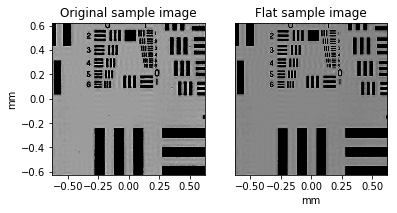

In [17]:
#Create filtered sample spectrum
filtered_sample_flat = lens*ef_fft_flat

#Propagate filtered sample spectrum to image plane
detected_img_flat = np.fft.ifft2(filtered_sample_flat)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img_flat = abs(detected_img_flat)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img_flat, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Flat sample image')
plt.show()

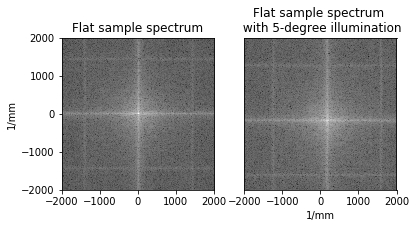

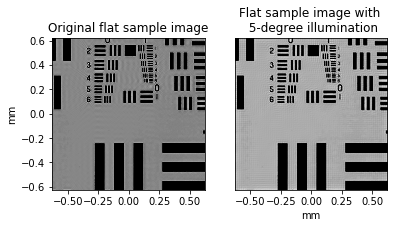

In [18]:
# Re-illuminate the flat sample with 5-degree illumination
emerging_field_flat5 = illumination_plane_wave5*sample_flat

# Take 2D fourier transform of emerging field of flat sample
ef_fft_flat5 = np.fft.fft2(emerging_field_flat5)
ef_fft_flat5 = np.fft.fftshift(ef_fft_flat5)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft_flat), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Flat sample spectrum')

ax1.imshow(np.abs(ef_fft_flat5), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Flat sample spectrum \n with 5-degree illumination')
plt.show()

#Create filtered sample spectrum
detected_fft_flat5 = lens*ef_fft_flat5

#Propagate filtered sample spectrum to image plane
detected_img_flat5 = np.fft.ifft2(detected_fft_flat5)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img_flat5 = abs(detected_img_flat5)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img_flat, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original flat sample image')

ax1.imshow(detected_img_flat5, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Flat sample image with \n 5-degree illumination')
plt.show()

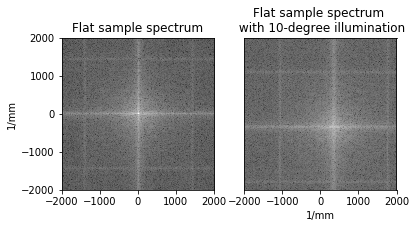

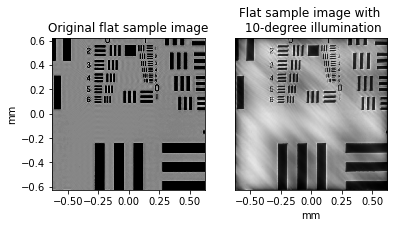

In [19]:
# Re-illuminate the flat sample with 10-degree illumination
emerging_field_flat10 = illumination_plane_wave10*sample_flat

# Take 2D fourier transform of emerging field of flat sample
ef_fft_flat10 = np.fft.fft2(emerging_field_flat10)
ef_fft_flat10 = np.fft.fftshift(ef_fft_flat10)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft_flat), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Flat sample spectrum')

ax1.imshow(np.abs(ef_fft_flat10), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Flat sample spectrum \n with 10-degree illumination')
plt.show()

#Create filtered sample spectrum
detected_fft_flat10 = lens*ef_fft_flat10

#Propagate filtered sample spectrum to image plane
detected_img_flat10 = np.fft.ifft2(detected_fft_flat10)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img_flat10 = abs(detected_img_flat10)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img_flat, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original flat sample image')

ax1.imshow(detected_img_flat10, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Flat sample image with \n 10-degree illumination')
plt.show()

#### At 10-degree illumination, we have the "shadow" similar to the sample with thickness, due to the shift of the ray angle. However, we don't observe the distorted lower-right part of the image because the sample is now flat, having no scattered photons illuminated on other parts of the sample.

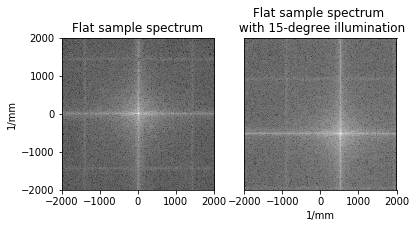

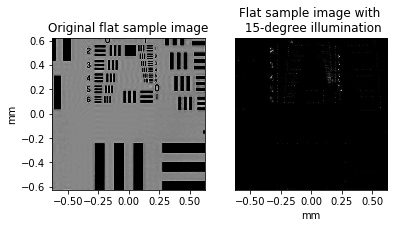

In [20]:
# Re-illuminate the flat sample with 5-degree illumination
emerging_field_flat15 = illumination_plane_wave15*sample_flat

# Take 2D fourier transform of emerging field of flat sample
ef_fft_flat15 = np.fft.fft2(emerging_field_flat15)
ef_fft_flat15 = np.fft.fftshift(ef_fft_flat15)

# plot the Fourier transform of the sample in inverse mm coordinates
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(np.abs(ef_fft_flat), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
ax2.set_ylabel('1/mm')
ax2.set_title('Flat sample spectrum')

ax1.imshow(np.abs(ef_fft_flat15), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
ax1.set_xlabel('1/mm')
ax1.set_yticks([])
ax1.set_title('Flat sample spectrum \n with 15-degree illumination')
plt.show()

#Create filtered sample spectrum
detected_fft_flat15 = lens*ef_fft_flat15

#Propagate filtered sample spectrum to image plane
detected_img_flat15 = np.fft.ifft2(detected_fft_flat15)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img_flat15 = abs(detected_img_flat15)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img_flat, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original flat sample image')

ax1.imshow(detected_img_flat15, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Flat sample image with \n 15-degree illumination')
plt.show()

#### At critical angle of 15, similar to the original sample, the flat sample also reflects all the photons.

# (d) (Extra credit)

In [21]:
#Define lens transfer function as matrix with 1's within desired radius, 0's outside
def make_apod_lens(outer, inner, size):
    lens = np.zeros((size, size))
    if outer < inner:
        raise AttributeError(
                'Current version does not support both HR and 3-channel image due to limitation of memory.')
    for i in range(size):
        for j in range(size):
            dist = np.sqrt((i-size/2)**2+(j-size/2)**2)
            if dist < outer/2*size and dist > inner/2*size:
                lens[i,j] = 1
    return lens

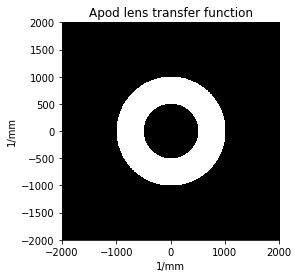

In [22]:
apod_lens = make_apod_lens(1/2, 1/4, len(fx))

# Display apod lens
plt.imshow(apod_lens, extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
plt.ylabel('1/mm')
plt.title('Apod lens transfer function')
plt.show()

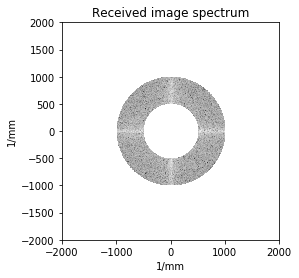

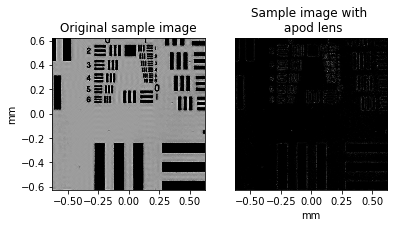

In [23]:
#Create filtered sample spectrum
filtered_sample_fft_apod = apod_lens*ef_fft
plt.imshow(np.abs(filtered_sample_fft_apod), norm=colors.LogNorm(), extent=(fx[0], fx[-1], fx[0], fx[-1]))
plt.xlabel('1/mm')
plt.ylabel('1/mm')
plt.title('Received image spectrum')
plt.show()

#Propagate filtered sample spectrum to image plane
detected_img_apod = np.fft.ifft2(filtered_sample_fft_apod)

#Detect intensity (squared magnitude) of resulting field on sensor
detected_img_apod = abs(detected_img_apod)**2

#Plot resulting image
_, (ax2, ax1) = plt.subplots(1,2)
ax2.imshow(detected_img, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
plt.xlabel('mm')
ax2.set_ylabel('mm')
ax2.set_title('Original sample image')

ax1.imshow(detected_img_apod, extent=(x_dash[0], x_dash[-1], x_dash[0], x_dash[-1]))
ax1.set_xlabel('mm')
ax1.set_yticks([])
ax1.set_title('Sample image with \n apod lens')
plt.show()

#### This "ring" (apod) lens serves as the bandpass filter, eliminating both low- and high-frequency signal. Thus, we can see that some edges are preserved but a lot of DC signal within the dark regions of the sample are filtered out in the detected image.